<a href="https://colab.research.google.com/github/TienLungSun/LLM/blob/main/Image%20caption%20with%20Qwen2-VL-7B-Instruct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct

In [1]:
pip install --upgrade transformers

In [4]:
pip install qwen-vl-utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 63.6 MB/s eta 0:00:00


In [5]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

In [6]:
# default: Load the model on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
)

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}


model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

In [7]:
# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [8]:
# 打開本地影像檔案 "aaa.jpg"
image = Image.open("2.jpg")

In [15]:
# The default range for the number of visual tokens per image in the model is 4-16384. You can set min_pixels and max_pixels according to your needs, such as a token count range of 256-1280, to balance speed and memory usage.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "2.jpg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

In [16]:
# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

In [17]:
image_inputs, video_inputs = process_vision_info(messages)

In [18]:
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [19]:
# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)

In [20]:
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

In [21]:
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

['The image depicts a scene inside a room with a polished, speckled floor. There are three individuals present in the room. The person in the foreground is a woman wearing a light-colored cardigan over a white top, paired with white shorts and white sneakers. She is walking towards the center of the room, with her head slightly bowed and her gaze directed downwards.\n\nTo her right, there is a small robot with a festive appearance, possibly a toy or a decorative item. The robot has a green cone-shaped head with a face drawn on it, and it is placed on the floor. The robot appears to be moving or being pushed']


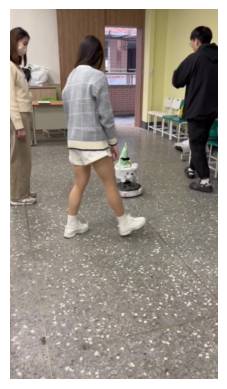

In [22]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis('off')  # 隱藏座標軸
plt.show()